In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
import joblib

In [36]:
df = pd.read_csv('historical_weather.csv')
df_key = pd.read_csv('submission_key.csv')
df_sub = pd.read_csv('sample_submission.csv')

In [37]:
df_key.head()

,submission_ID,city_id,date
0,1,C001,2019-01-01
1,2,C001,2019-01-02
2,3,C001,2019-01-03
3,4,C001,2019-01-04
4,5,C001,2019-01-05


In [38]:
df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [39]:
df.isna().sum()

city_id                    0
date                       0
avg_temp_c              1224
min_temp_c              5886
max_temp_c              7493
precipitation_mm       69744
snow_depth_mm         170100
avg_wind_dir_deg       35394
avg_wind_speed_kmh     22472
dtype: int64

In [40]:
df['date'] = pd.to_datetime(df['date'])
df['date'].head()

0   2014-01-01
1   2014-01-02
2   2014-01-03
3   2014-01-04
4   2014-01-05
Name: date, dtype: datetime64[ns]

In [41]:
# Fill missing avg_temp_c values with mean
df['avg_temp_c'].fillna(df['avg_temp_c'].mean(), inplace=True)
df['avg_wind_speed_kmh'].fillna(df['avg_wind_speed_kmh'].mean(), inplace=True)

# Fill missing min_temp_c values with median
df['min_temp_c'].fillna(df['min_temp_c'].median(), inplace=True)
df['max_temp_c'].fillna(df['max_temp_c'].median(), inplace=True)

# guessing the missing values are forwarded
df['min_temp_c'].fillna(method='ffill', inplace=True)
df['max_temp_c'].fillna(method='ffill', inplace=True)

# guessing the missing values are 0
df['precipitation_mm'].fillna(0, inplace=True)
df['avg_wind_dir_deg'].fillna(0, inplace=True)
df['snow_depth_mm'].fillna(0, inplace=True)

df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8
3,C001,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0


In [42]:
df.isna().sum()

city_id               0
date                  0
avg_temp_c            0
min_temp_c            0
max_temp_c            0
precipitation_mm      0
snow_depth_mm         0
avg_wind_dir_deg      0
avg_wind_speed_kmh    0
dtype: int64

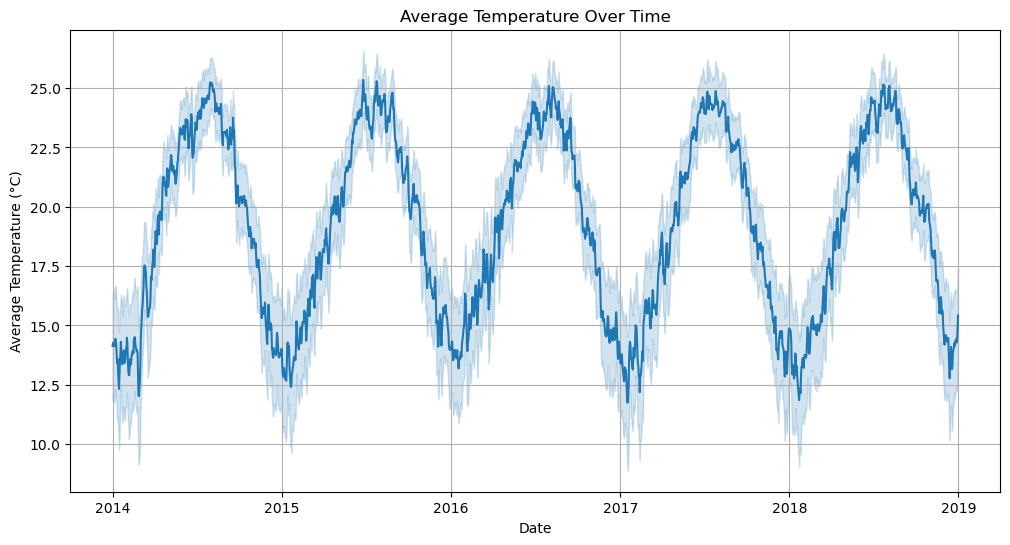

In [43]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='avg_temp_c')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

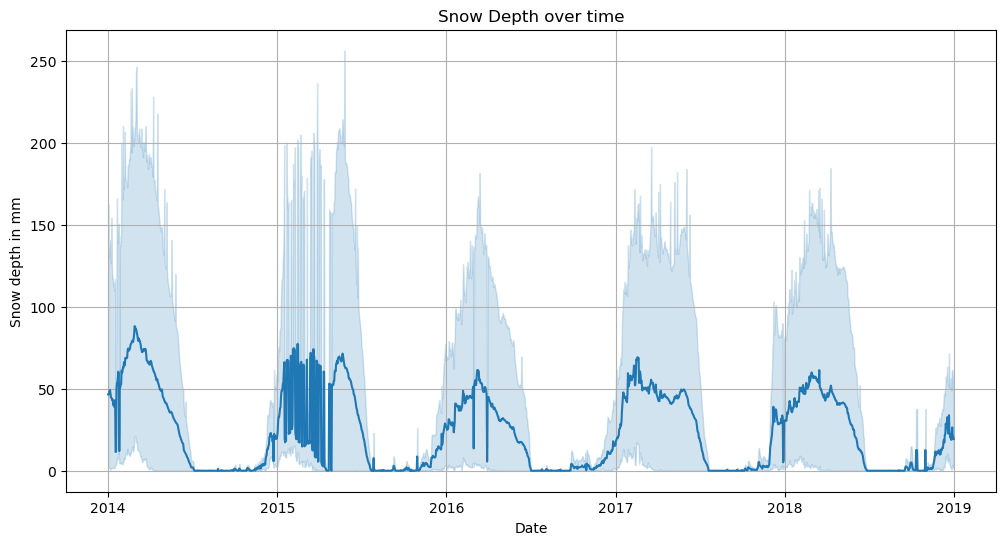

In [44]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='snow_depth_mm')
plt.title('Snow Depth over time')
plt.xlabel('Date')
plt.ylabel('Snow depth in mm')
plt.grid(True)
plt.show()

In [45]:
df.drop(columns='city_id').corr()

,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
date,1.000000,0.008775,0.021146,0.005173,0.015435,-0.015864,0.255240,-0.037769
avg_temp_c,0.008775,1.000000,0.954171,0.954602,0.008493,-0.186838,-0.119732,-0.115246
min_temp_c,0.021146,0.954171,1.000000,0.898368,0.040525,-0.172899,-0.094240,-0.076132
max_temp_c,0.005173,0.954602,0.898368,1.000000,-0.017666,-0.197406,-0.133600,-0.151355
precipitation_mm,0.015435,0.008493,0.040525,-0.017666,1.000000,0.047230,0.007249,0.038948
snow_depth_mm,-0.015864,-0.186838,-0.172899,-0.197406,0.047230,1.000000,0.042509,0.139023
avg_wind_dir_deg,0.255240,-0.119732,-0.094240,-0.133600,0.007249,0.042509,1.000000,0.140190
avg_wind_speed_kmh,-0.037769,-0.115246,-0.076132,-0.151355,0.038948,0.139023,0.140190,1.000000


In [58]:
df_arima = df.copy()

df_arima.sort_values(by='date', inplace=True)
df_arima.set_index('date', inplace=True)

df_arima = df_arima['avg_temp_c']
train_data = df_arima[:'2017-12-31']
test_data = df_arima['2018-01-01':]

In [59]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(train_data)

Results of Dickey-Fuller Test:
Test Statistic                -1.102540e+01
p-value                        5.845483e-20
#Lags Used                     7.500000e+01
Number of Observations Used    1.457700e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


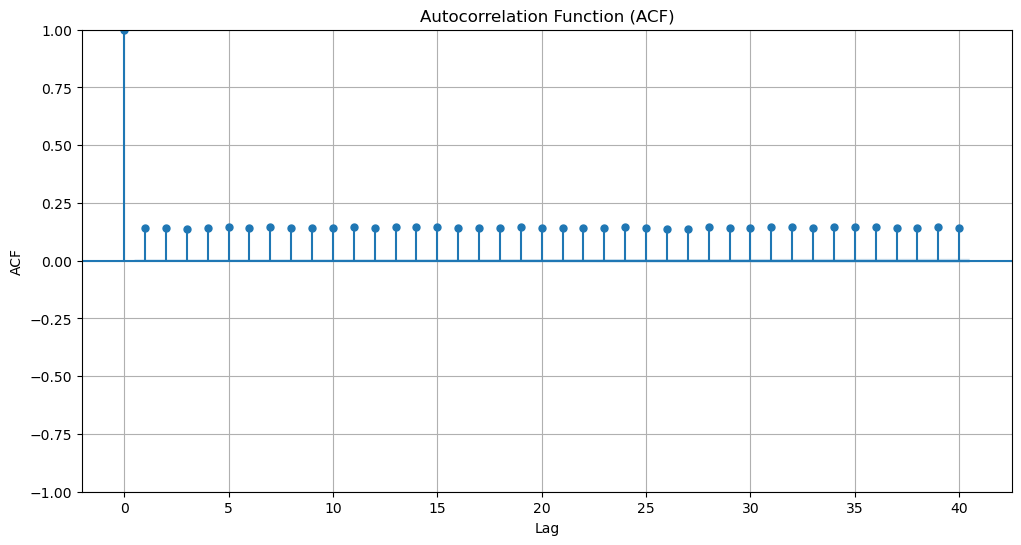

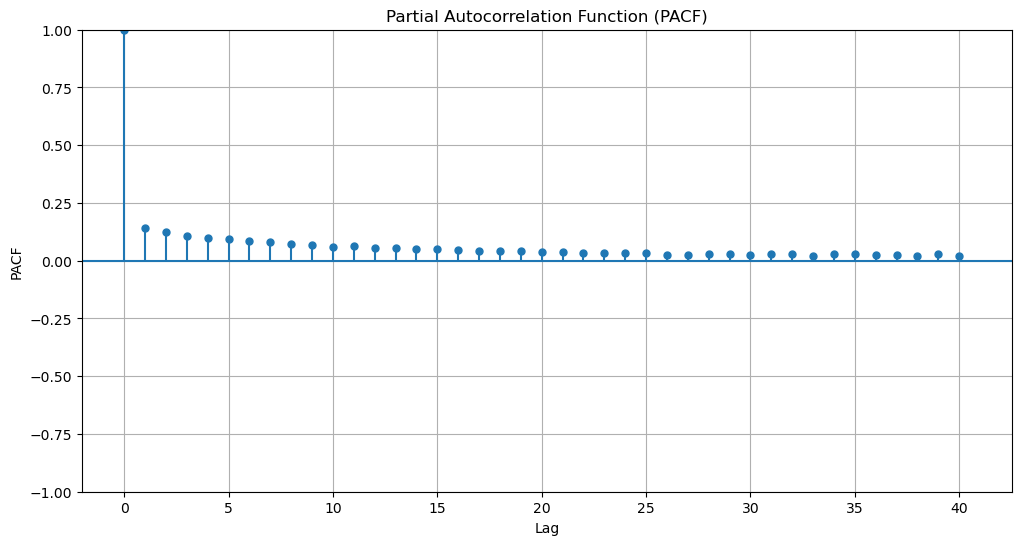

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(train_data, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(train_data, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.grid(True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:             avg_temp_c   No. Observations:               145846
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -529238.175
Date:                Fri, 21 Jun 2024   AIC                        1058484.351
Time:                        20:41:14   BIC                        1058523.912
Sample:                             0   HQIC                       1058496.157
                             - 145846                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1979      2.290      7.511      0.000      12.710      21.686
ar.L1          1.0000   1.88e-05   5.33e+04      0.000       1.000       1.000
ma.L1         -0.9971      0.000  -5096.129      0.0

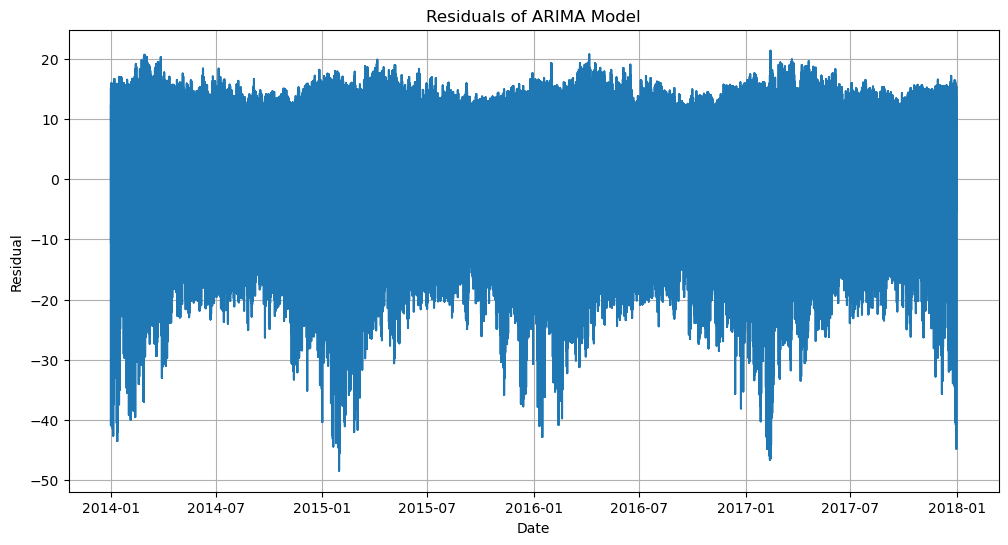

RMSE: 10.62 °C


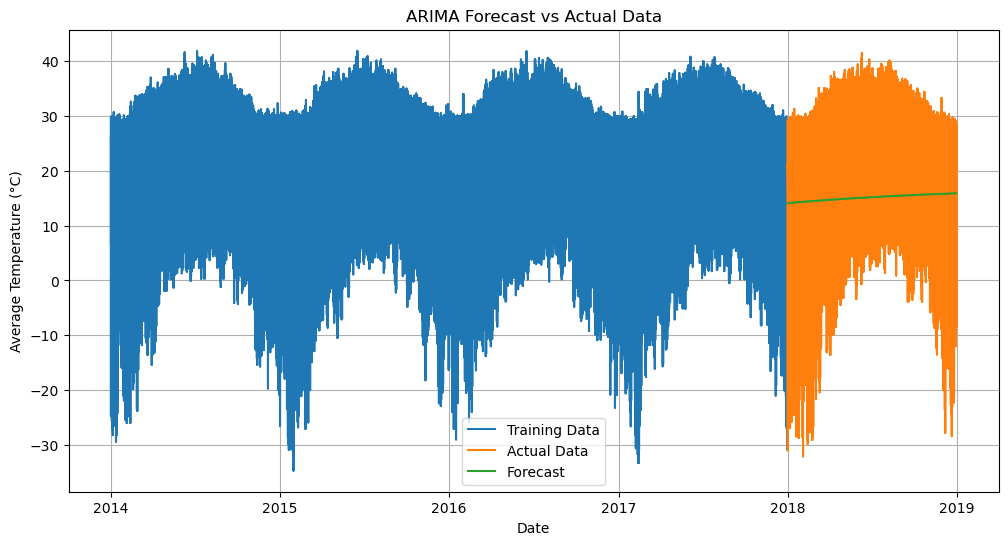

In [61]:
model = ARIMA(train_data, order=(1, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

# Forecast
fc = model_fit.forecast(len(test_data))

# Convert fc to a Series (if not already)
fc_series = pd.Series(fc, index=test_data.index)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_data, fc))
print(f'RMSE: {rmse:.2f} °C')

# Plot forecasts against actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Data')
plt.plot(test_data.index, fc, label='Forecast')
plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [81]:
model_final = ARIMA(df_arima, order=(1, 0, 1))
model_final_fit = model_final.fit()

print(model_final_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             avg_temp_c   No. Observations:               182338
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -661733.459
Date:                Fri, 21 Jun 2024   AIC                        1323474.917
Time:                        22:38:22   BIC                        1323515.372
Sample:                             0   HQIC                       1323486.872
                             - 182338                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2276      0.984     18.517      0.000      16.298      20.157
ar.L1          0.9999   1.81e-05   5.52e+04      0.000       1.000       1.000
ma.L1         -0.9971      0.000  -5532.159      0.0

In [48]:
feature_df = df.copy()
feature_df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8
3,C001,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0


In [23]:
response_map = {}
cities = feature_df['city_id'].unique() 
for i in range(len(cities)):
    response_map[cities[i]] = i
    
print(response_map)

{'C001': 0, 'C002': 1, 'C003': 2, 'C004': 3, 'C005': 4, 'C007': 5, 'C008': 6, 'C009': 7, 'C010': 8, 'C011': 9, 'C012': 10, 'C013': 11, 'C014': 12, 'C015': 13, 'C016': 14, 'C017': 15, 'C018': 16, 'C020': 17, 'C022': 18, 'C023': 19, 'C024': 20, 'C025': 21, 'C027': 22, 'C028': 23, 'C029': 24, 'C030': 25, 'C031': 26, 'C033': 27, 'C034': 28, 'C035': 29, 'C036': 30, 'C037': 31, 'C038': 32, 'C039': 33, 'C040': 34, 'C042': 35, 'C043': 36, 'C044': 37, 'C045': 38, 'C046': 39, 'C047': 40, 'C048': 41, 'C049': 42, 'C051': 43, 'C053': 44, 'C054': 45, 'C055': 46, 'C056': 47, 'C057': 48, 'C058': 49, 'C059': 50, 'C061': 51, 'C062': 52, 'C064': 53, 'C065': 54, 'C066': 55, 'C067': 56, 'C068': 57, 'C069': 58, 'C070': 59, 'C071': 60, 'C072': 61, 'C073': 62, 'C074': 63, 'C076': 64, 'C077': 65, 'C078': 66, 'C079': 67, 'C081': 68, 'C082': 69, 'C083': 70, 'C084': 71, 'C085': 72, 'C086': 73, 'C087': 74, 'C088': 75, 'C089': 76, 'C090': 77, 'C091': 78, 'C092': 79, 'C093': 80, 'C094': 81, 'C095': 82, 'C096': 83, '

In [49]:
feature_df['city_id'] = feature_df['city_id'].map(response_map)
feature_df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,0,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2
1,0,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0
2,0,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8
3,0,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3
4,0,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0


In [50]:
feature_df['year'] = feature_df['date'].dt.year
feature_df['month'] = feature_df['date'].dt.month
feature_df['day'] = feature_df['date'].dt.day
feature_df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,year,month,day
0,0,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2,2014,1,1
1,0,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0,2014,1,2
2,0,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8,2014,1,3
3,0,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3,2014,1,4
4,0,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0,2014,1,5


In [29]:
feature_df.isna().sum()

city_id               0
date                  0
min_temp_c            0
max_temp_c            0
precipitation_mm      0
snow_depth_mm         0
avg_wind_dir_deg      0
avg_wind_speed_kmh    0
year                  0
month                 0
day                   0
dtype: int64

In [62]:
train = feature_df[feature_df['date'] < '2018-01-01']
test = feature_df[feature_df['date'] >= '2018-01-01']

In [63]:
X_train = train.drop(columns=['date', 'avg_temp_c'])
y_train = train['avg_temp_c']
X_test = test.drop(columns=['date', 'avg_temp_c'])
y_test = test['avg_temp_c']

In [64]:
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

In [67]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_pred = rf_model.fit(X_train, y_train).predict(X_test)
np.sqrt(mean_squared_error(y_pred=rf_pred, y_true=y_test))

0.938020114638547

In [71]:
rf_pred

array([ 8.775     ,  8.551     ,  8.975     , ..., 22.679     ,
       21.77837516, 20.10812547])

In [72]:
y_test

1461       8.1
1462       8.5
1463       9.6
1464      11.8
1465      11.6
          ... 
182333    22.0
182334    21.9
182335    22.4
182336    21.6
182337    20.2
Name: avg_temp_c, Length: 36492, dtype: float64

In [73]:
X_train_final = feature_df.drop(columns=['date', 'avg_temp_c'])
y_train_final = feature_df['avg_temp_c']

In [74]:
rf_model_final = RandomForestRegressor(n_jobs=-1)
rf_model_final.fit(X_train_final, y_train_final)

RandomForestRegressor(n_jobs=-1)

In [75]:
joblib.dump(rf_model_final, 'weather_prediction_rf_model.pkl')

['weather_prediction_rf_model.pkl']

In [76]:
df_copy = df.copy()

In [78]:
df_copy['year'] = df_copy['date'].dt.year
df_copy['month'] = df_copy['date'].dt.month
df_copy['day'] = df_copy['date'].dt.day
df_copy.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,year,month,day
0,C001,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2,2014,1,1
1,C001,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0,2014,1,2
2,C001,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8,2014,1,3
3,C001,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3,2014,1,4
4,C001,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0,2014,1,5


In [79]:
df_copy['city_id'] = df_copy['city_id'].map(response_map)
df_copy.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,year,month,day
0,0,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2,2014,1,1
1,0,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0,2014,1,2
2,0,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8,2014,1,3
3,0,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3,2014,1,4
4,0,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0,2014,1,5


In [84]:
features = ['city_id', 'min_temp_c', 'max_temp_c', 'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'year', 'month', 'day']
X = df_copy[features]
y = df_copy['avg_temp_c']

In [85]:
df_copy['predicted_avg_temp_c'] = rf_model_final.predict(X)

In [86]:
df_copy.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,year,month,day,predicted_avg_temp_c
0,0,2014-01-01,6.6,-1.4,11.6,0.0,0.0,168.0,6.2,2014,1,1,6.305
1,0,2014-01-02,9.3,6.3,13.3,0.0,0.0,155.0,10.0,2014,1,2,9.287
2,0,2014-01-03,7.6,1.9,14.0,0.0,0.0,0.0,5.8,2014,1,3,7.663
3,0,2014-01-04,7.6,3.9,13.3,0.0,0.0,291.0,11.3,2014,1,4,7.928
4,0,2014-01-05,8.6,0.5,16.9,0.0,0.0,0.0,5.0,2014,1,5,8.256


In [90]:
np.sqrt(mean_squared_error(y_true=df_copy['avg_temp_c'], y_pred=df_copy['predicted_avg_temp_c']))

0.36975823134591446

In [94]:
lookup_table = df_copy.groupby(['city_id', 'year', 'month', 'day'])['predicted_avg_temp_c'].mean().reset_index()
lookup_table

,city_id,year,month,day,predicted_avg_temp_c
0,0,2014,1,1,6.305
1,0,2014,1,2,9.287
2,0,2014,1,3,7.663
3,0,2014,1,4,7.928
4,0,2014,1,5,8.256
...,...,...,...,...,...
182333,99,2018,12,27,22.038
182334,99,2018,12,28,21.810
182335,99,2018,12,29,22.438
182336,99,2018,12,30,21.848


In [99]:
future_dates = pd.date_range(start='2019-01-01', end='2019-12-31')
future_df = pd.DataFrame(future_dates, columns=['date'])

# Repeat for each city
cities = df_copy['city_id'].unique()
future_df = future_df.assign(key=1).merge(pd.DataFrame(cities, columns=['city_id']).assign(key=1), on='key').drop('key', axis=1)

# Extract year, month, day
future_df['year'] = future_df['date'].dt.year
future_df['month'] = future_df['date'].dt.month
future_df['day'] = future_df['date'].dt.day

# Add necessary feature columns and fill with zeros (or mean values if available)
for feature in features:
    if feature not in future_df.columns:
        future_df[feature] = 0  # or use data[feature].mean()

# Predict future temperatures
future_df['predicted_avg_temp_c'] = rf_model_final.predict(future_df[features])

# Create the lookup table
lookup_table = future_df[['city_id', 'year', 'month', 'day', 'predicted_avg_temp_c']]

In [100]:
def predict_avg_temp(city_id, date):
    # Extract year, month, and day from the date
    year = pd.Timestamp(date).year
    month = pd.Timestamp(date).month
    day = pd.Timestamp(date).day
    
    # Lookup the predicted temperature
    pred = lookup_table[(lookup_table['city_id'] == city_id) &
                        (lookup_table['year'] == year) &
                        (lookup_table['month'] == month) &
                        (lookup_table['day'] == day)]
    
    if not pred.empty:
        return pred['predicted_avg_temp_c'].values[0]
    else:
        return np.nan  # or some default value

In [102]:
future_df

,date,city_id,year,month,day,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,predicted_avg_temp_c
0,2019-01-01,0,2019,1,1,0,0,0,0,0,0,0.782
1,2019-01-01,1,2019,1,1,0,0,0,0,0,0,0.782
2,2019-01-01,2,2019,1,1,0,0,0,0,0,0,0.782
3,2019-01-01,3,2019,1,1,0,0,0,0,0,0,0.782
4,2019-01-01,4,2019,1,1,0,0,0,0,0,0,0.782
...,...,...,...,...,...,...,...,...,...,...,...,...
36495,2019-12-31,95,2019,12,31,0,0,0,0,0,0,0.028
36496,2019-12-31,96,2019,12,31,0,0,0,0,0,0,0.028
36497,2019-12-31,97,2019,12,31,0,0,0,0,0,0,0.028
36498,2019-12-31,98,2019,12,31,0,0,0,0,0,0,0.028


In [101]:
predicted_temp = predict_avg_temp('C001', '2019-01-03')
print(f'Predicted Average Temperature: {predicted_temp}')

Predicted Average Temperature: nan


In [92]:
df_key['date'] = pd.to_datetime(df_key['date'])
df_key_copy = df_key.copy()

df_key_copy['year'] = df_key_copy['date'].dt.year
df_key_copy['month'] = df_key_copy['date'].dt.month
df_key_copy['day'] = df_key_copy['date'].dt.day

df_key_copy.rename(columns = {'city_id':'city_id_2'}, inplace = True)

df_key_copy['city_id'] = df_key_copy['city_id_2'].map(response_map)
df_key_copy.head()

,submission_ID,city_id_2,date,year,month,day,city_id
0,1,C001,2019-01-01,2019,1,1,0
1,2,C001,2019-01-02,2019,1,2,0
2,3,C001,2019-01-03,2019,1,3,0
3,4,C001,2019-01-04,2019,1,4,0
4,5,C001,2019-01-05,2019,1,5,0


In [111]:
df_key.drop(columns=['submission_ID', 'city_id_2', 'date'])

,year,month,day,city_id
0,2019,1,1,0
1,2019,1,2,0
2,2019,1,3,0
3,2019,1,4,0
4,2019,1,5,0
...,...,...,...,...
695,2019,1,3,99
696,2019,1,4,99
697,2019,1,5,99
698,2019,1,6,99


In [112]:
colnames = feature_df.columns
colnames

Index(['city_id', 'year', 'month', 'day'], dtype='object')

In [113]:
df_key = df_key[colnames]
df_key

,city_id,year,month,day
0,0,2019,1,1
1,0,2019,1,2
2,0,2019,1,3
3,0,2019,1,4
4,0,2019,1,5
...,...,...,...,...
695,99,2019,1,3
696,99,2019,1,4
697,99,2019,1,5
698,99,2019,1,6


In [115]:
df_key_scaled = scaler.fit_transform(df_key)
df_key_scaled = pd.DataFrame(df_key_scaled, columns=df_key.columns)
df_key_scaled

,city_id,year,month,day
0,-1.714816,0.0,0.0,-1.5
1,-1.714816,0.0,0.0,-1.0
2,-1.714816,0.0,0.0,-0.5
3,-1.714816,0.0,0.0,0.0
4,-1.714816,0.0,0.0,0.5
...,...,...,...,...
695,1.714816,0.0,0.0,-0.5
696,1.714816,0.0,0.0,0.0
697,1.714816,0.0,0.0,0.5
698,1.714816,0.0,0.0,1.0


In [120]:
index = 0
while index < submission.shape[0]:
    features = df_key_scaled.loc[index].values.reshape(1, -1)
    predicted = rf_model.predict(features)[0]  # Get the first element since predict returns an array
    submission.loc[index, 'avg_temp_c'] = predicted
    index += 1
    
submission  

,submission_ID,avg_temp_c
0,1,26.975
1,2,25.601
2,3,25.155
3,4,22.873
4,5,22.877
...,...,...
695,696,18.007
696,697,10.244
697,698,13.005
698,699,14.902


In [121]:
submission.to_csv('085.csv', index=False)